# Chapter 18: Policy-Based Deep Reinforcement Learning





New Skills in This Chapter:

• Creating a neural network to represent a policy

• Preprocessing raw pixels from the Atari Pong game

• Selecting actions based on recommendations from the policy network

• Training the policy network based on observed rewards

• Playing the Pong game using the trained policy network

***
*The idea behind reinforcement learning is you don't necessarily know the actions you might take, so you explore the sequence of actions you should take by taking one that you think is a good idea and then observing how the world reacts. Like in a board game where you can react to how your opponent plays.* <br>
***
--Jeff Dean, Head of Google AI

***

In [1]:
import os

os.makedirs("files/ch18", exist_ok=True)

# 18.1. Policy-Based Reinforcement Learning

# 18.2. Get Started with Atari Games
In this section, you'll start to play the Atari Pong game in the OpenAI Gym environment and learn its features.

First, you need to install Atari games in OpenAI Gym in Python. Activate the virtual environment *MLA* on your computer and enter the following command in the Anaconda prompt (Windows) or a terminal (MAC or Linux):

`conda install -c conda-forge atari_py`

After conda installing Atari games, you need to install *ROMS* on your computer as well. Go to the link below 

http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html

and download the file *Roms.rar* to your computer. Extract the two folders, *ROMS* and *HC Roms*, and place them in a folder on your computer. For example, I place them in *C:\temp* on my computer. 

After that, run the following command in the Anaconda prompt (Windows) or a terminal (MAC or Linux) with the virtual environment *MLA* activated:

`python -m atari_py.import_roms <path to folder>`

Since I saved the files in *C:\temp* on my computer, I ran:

`python -m atari_py.import_roms C:\temp` 

to install ROMS. 

Also make sure that the version of gym installed on your computer is 0.15.7. See Chapter 10 on how to install the correct version of gym. 

Finally, you need to restart the Jupyter Notebook on your computer for the installed packages to take effect.

## 18.2.1. The Pong Game

In [2]:
import gym
env = gym.make("Pong-v0")
env.reset()
env.render()

True

In [3]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space in the Pong game is {actions}")
# Print out the observation space in this game
obs_space = env.observation_space
print(f"The observation space in the Pong game is {obs_space}")

The action space in the Pong game is Discrete(6)
The observation space in the Pong game is Box(210, 160, 3)


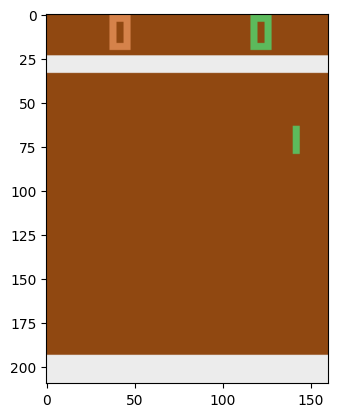

In [4]:
import matplotlib.pyplot as plt
import numpy as np

env.reset()
# Run 20 steps so the pong appears in the picture
for _ in range(20):
    action = np.random.choice(range(6))
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()

## 18.2.2. Process the Game Pictures 

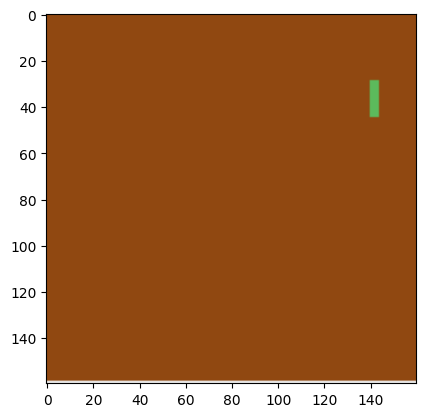

In [5]:
obs_cropped = obs[35:195]
plt.imshow(obs_cropped)
plt.show()

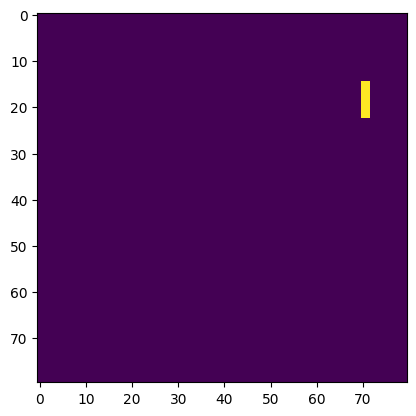

In [6]:
obs_downsized=obs_cropped[::2,::2,0]
obs_downsized[obs_downsized==144]=0
obs_downsized[obs_downsized==109]=0
obs_downsized[obs_downsized!=0]=1
plt.imshow(obs_downsized)
plt.show()

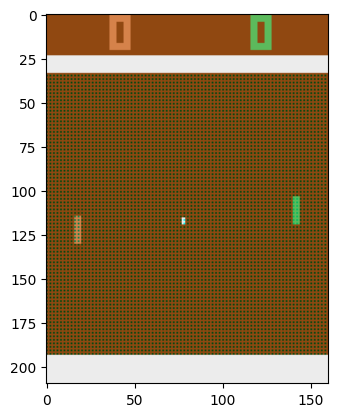

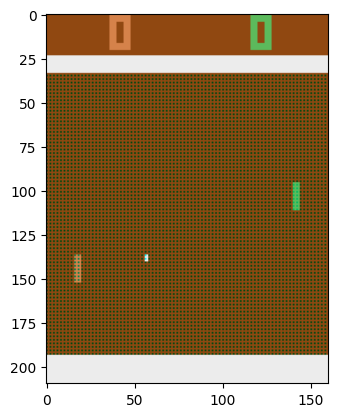

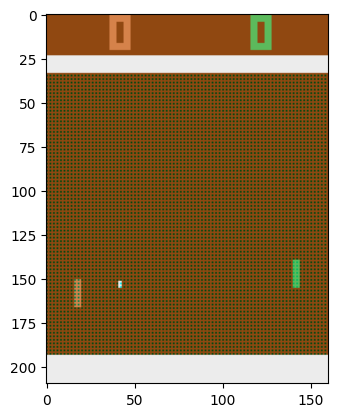

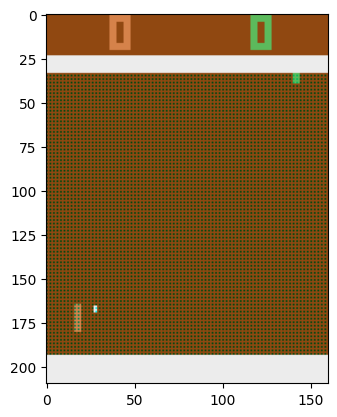

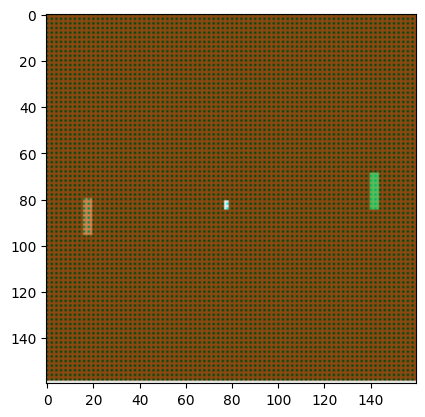

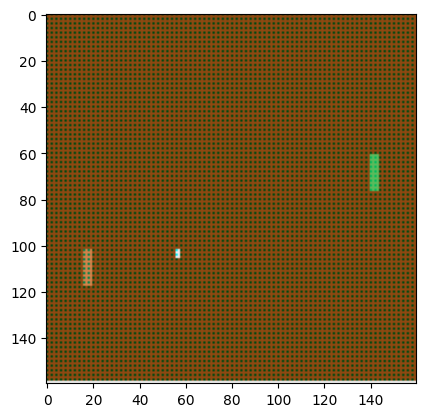

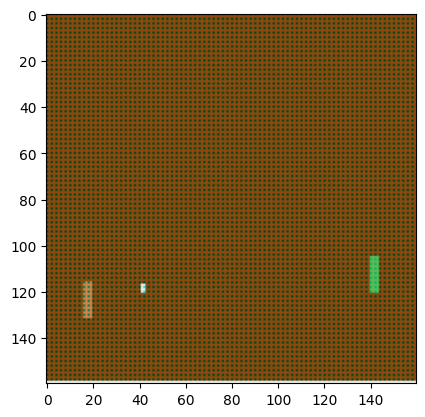

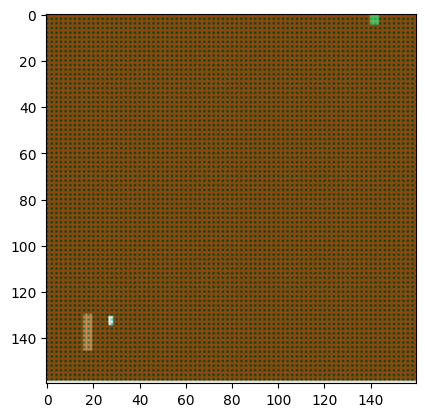

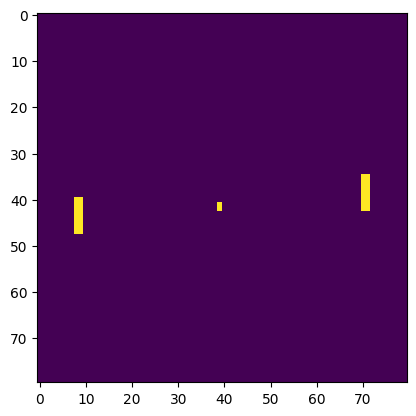

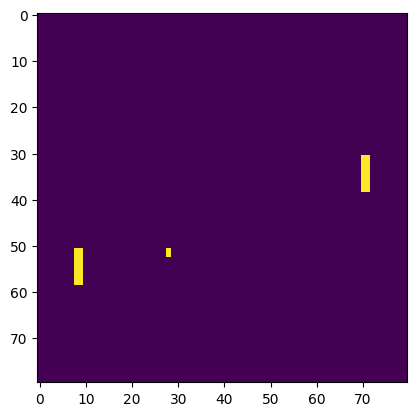

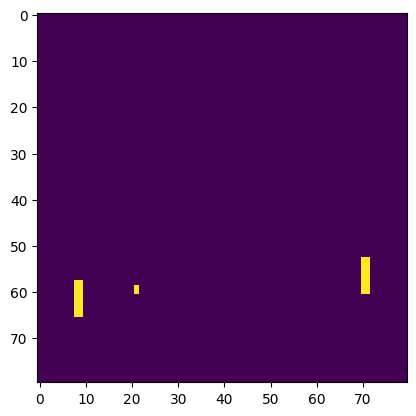

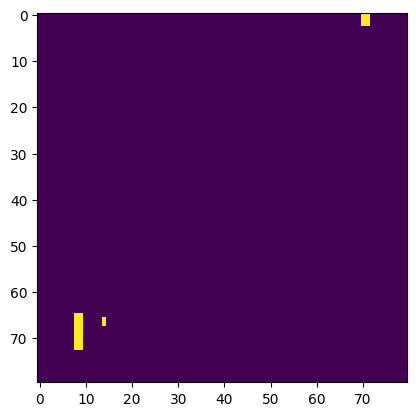

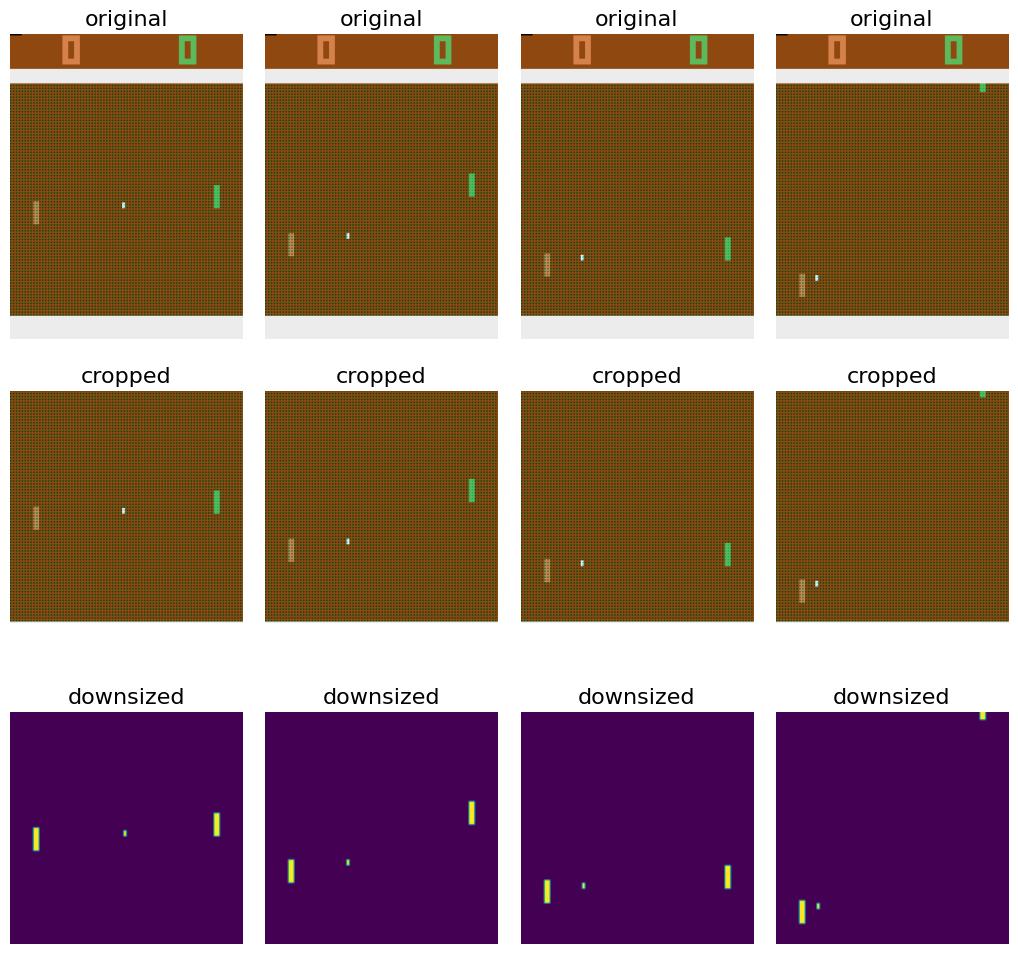

In [7]:
from utils.ch18util import preprocess

preprocess()

## 18.2.3. Use the Difference of Game Windows

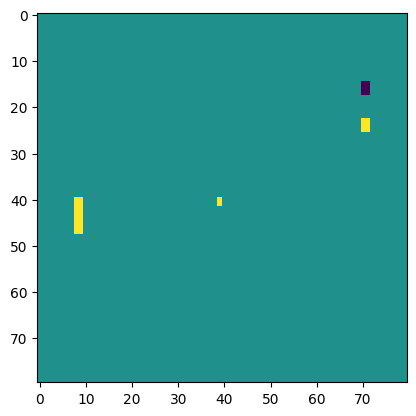

In [8]:
from utils.ch18util import prepro

next_obs, reward, done, info = env.step(2)
next_obs_downsized = prepro(next_obs).reshape(80,80)

dif = next_obs_downsized - obs_downsized
plt.imshow(dif)
plt.show()

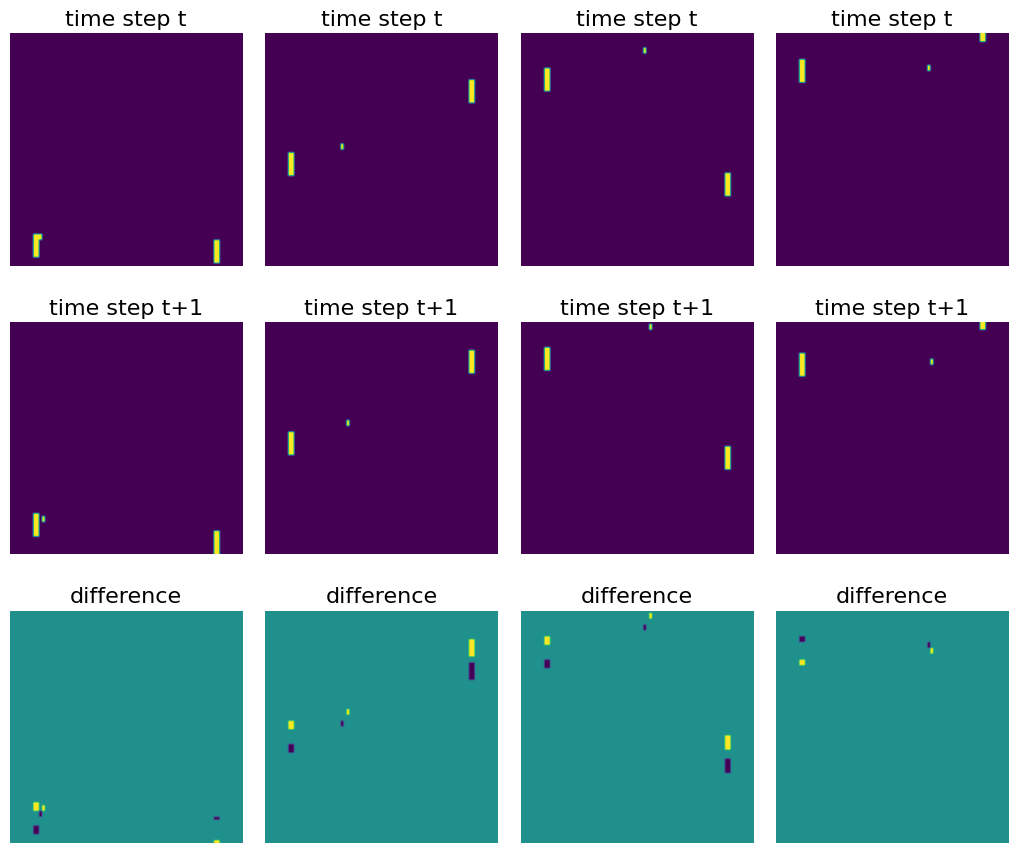

In [9]:
from utils.ch18util import difference

difference()

# 18.3. Train the Policy Gradient Agent


## 18.3.1. Create A Policy Network 

In [10]:
H = 200 
learning_rate = 1e-4
gamma = 0.99 
decay_rate = 0.99 
D = 80 * 80 
def sigmoid(x): 
    return 1.0 / (1.0 + np.exp(-x)) 

In [11]:
def policy_forward(model,x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h 

In [12]:
def policy_backward(model,eph, epdlogp, epx):
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

In [13]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        if r[t] != 0: 
            running_add = 0 
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

## 18.3.2. Train the Model


In [14]:
def policy_pong(test=False,resume=False,render=False,cutoff=-14):
    rewards=deque(maxlen=100)
    if test:
        env = gym.make("PongDeterministic-v4")
        batch_size=1
    else:
        env = gym.make("Pong-v0")
        batch_size=10
    if resume:
        model = pickle.load(open('files/ch18/pg_pong.p','rb'))
    else:
        model = {}
        model['W1'] = np.random.randn(H,D) / np.sqrt(D) 
        model['W2'] = np.random.randn(H) / np.sqrt(H)   
    episode_count = 0
    while True:
        batchrewards=create_batch(env,render,model,batch_size)
        rewards += batchrewards
        episode_count += batch_size
        running_reward=np.mean(np.array(rewards)) 
        if episode_count % 100 == 0 or test==True:
            template = "running reward: {:.6f} at episode {}"
            print(template.format(running_reward,episode_count))
            pickle.dump(model,open('files/ch18/pg_pong.p','wb'))
        if test==False and running_reward>=cutoff:  
            break
        if test==True and episode_count>=3:  
            break         
    env.close()  

In [15]:
from utils.ch18util import policy_pong
env.close()
policy_pong(test=False,resume=False,render=True,cutoff=-21)

In [16]:
from utils.ch18util import policy_pong

policy_pong(test=False,resume=False,render=False,cutoff=-14)

# 18.4. Test the Policy Gradient Agent
We can now test the trained policy gradient agent. We'll first test three games to see the scores of the agent in these games. After that, we'll recrod the game windows to prepare for animations in the next section. 

First, we test three games by calling the *policy_pong()* function and setting the *test* argument to *True*:

In [17]:
policy_pong(test=True,resume=True,render=True)

running reward: 21.000000 at episode 1
running reward: 21.000000 at episode 2
running reward: 21.000000 at episode 3


In [18]:
from utils.ch18util import policy_forward
import numpy as np
import pickle
import gym

D = 80 * 80 
model = pickle.load(open('files/ch18/pg_pong.p', 'rb'))
env = gym.make("PongDeterministic-v4")
frames = []
observation = env.reset()
prev_x = None
reward_sum=0 
while True:
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x
    aprob, h = policy_forward(model,x)
    action = 2 if 0.5 < aprob else 3 
    observation, reward, done, info = env.step(action)
    env.render()
    reward_sum += reward
    frames.append(observation)
    if done: 
        print(f"the score is {reward_sum}")
        break
env.close()

the score is 21.0


# 18.5. Animate the Pong Games

## 18.5.1. Record Games with Random Moves


In [19]:
random_frames = []
observation = env.reset()
for _ in range(len(frames)):
    action = np.random.choice([2,3]) 
    observation, reward, done, info = env.step(action)
    random_frames.append(observation)
env.close()

## 18.5.2. Combine the Animations

In [20]:
import imageio

fs = []
for i in range(len(frames)):
    if i%2==0:
        f = frames[i]
        rf = random_frames[i]
        middle = np.full(f.shape, 255).astype("uint8")
        frf = np.concatenate([rf, middle, f], axis=1)
        fs.append(frf)
imageio.mimsave('files/ch18/pong_compare.gif', fs, duration=40) 

<img src="https://gattonweb.uky.edu/faculty/lium/ml/pong_compare.gif" />

## 18.5.3. Subplots of the Policy Gradient Agent


In [21]:
plots=frames[::100]

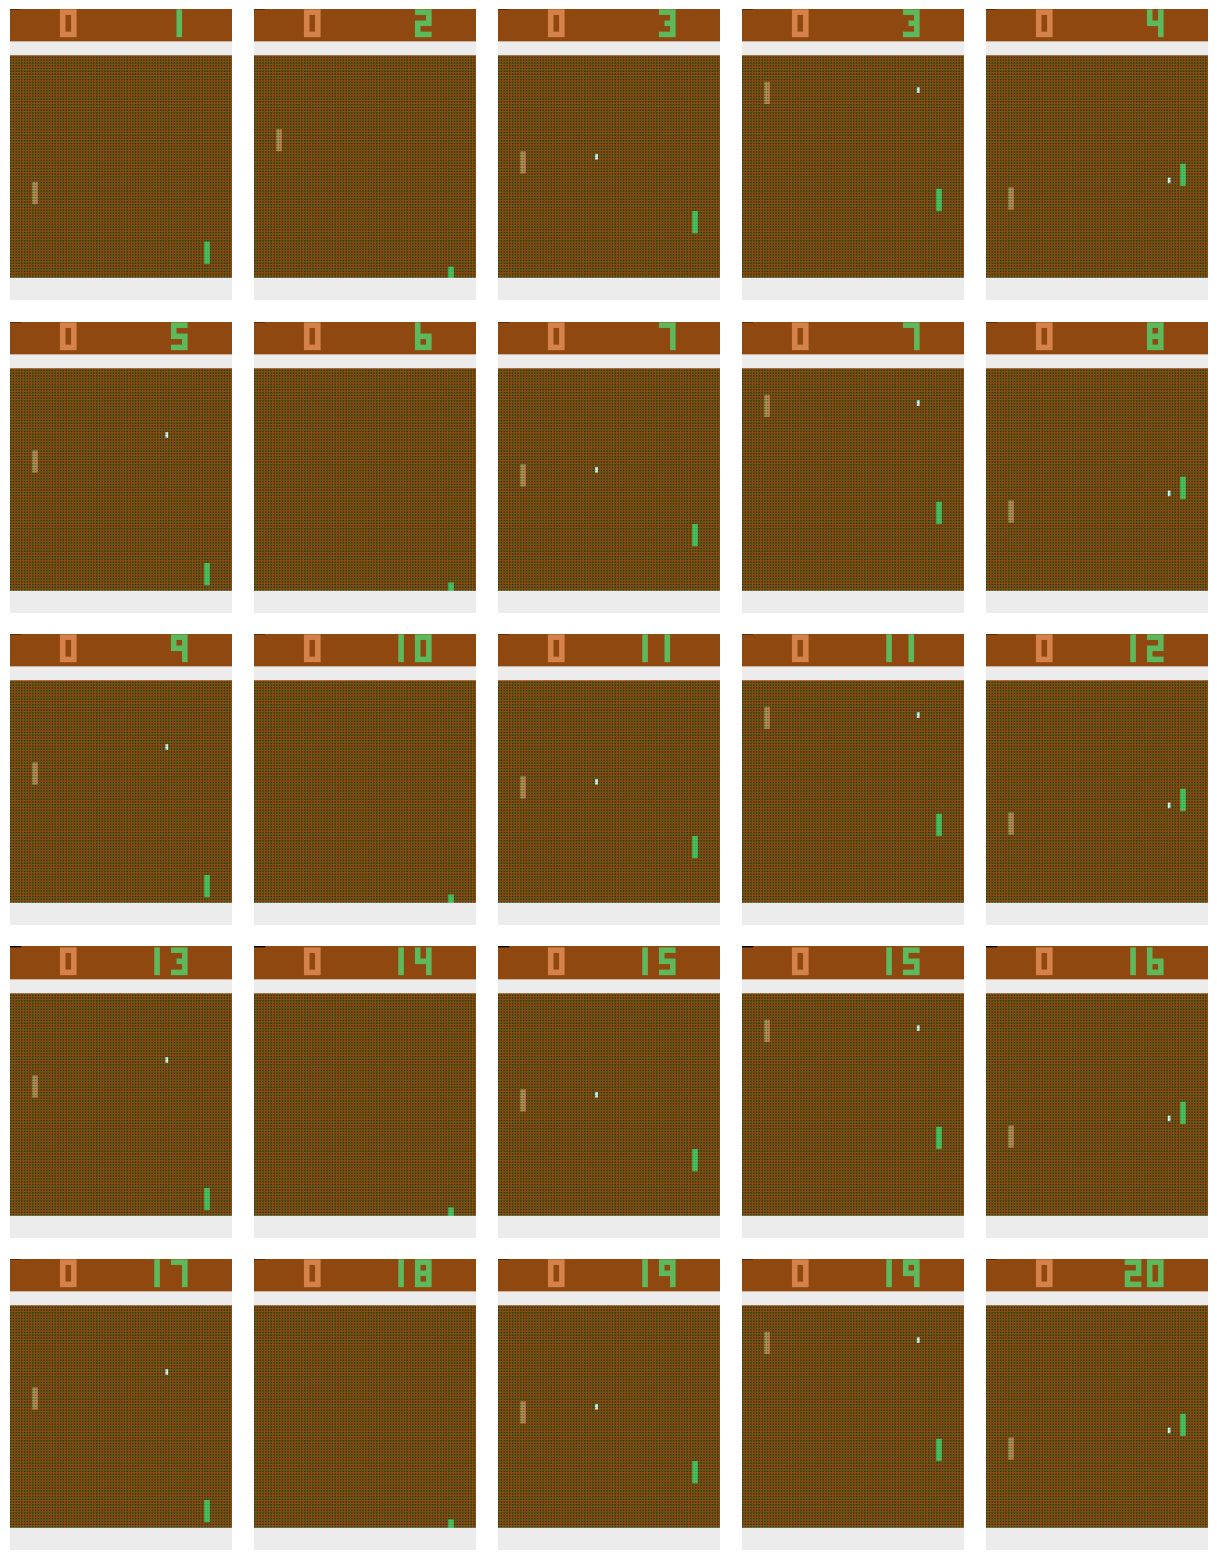

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,16),dpi=100)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(plots[i+1])
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
left=0.001, hspace=-0.1,wspace=0.1)
plt.savefig("files/ch18/trained_pg.png")

# 18.7 Exercises

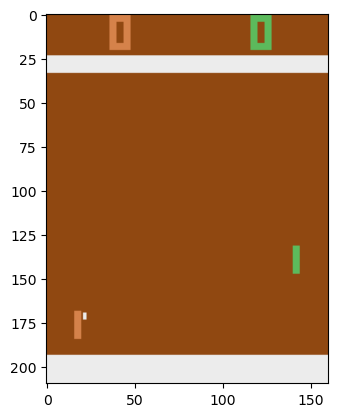

In [23]:
# answer to question 18.1
import matplotlib.pyplot as plt
import numpy as np

env.reset()
# Run 30 steps so the pong appears in the picture
for _ in range(30):
    action = np.random.choice(range(6))
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()

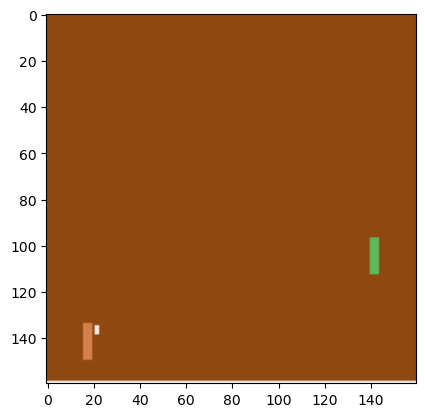

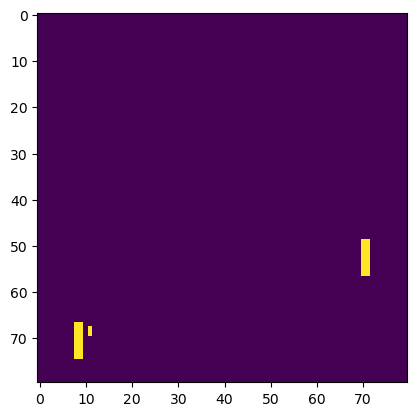

In [24]:
# answer to question 18.2
obs_cropped = obs[35:195]
plt.imshow(obs_cropped)
plt.show()
obs_downsized=obs_cropped[::2,::2,0]
obs_downsized[obs_downsized==144]=0
obs_downsized[obs_downsized==109]=0
obs_downsized[obs_downsized!=0]=1
plt.imshow(obs_downsized)
plt.show()

In [25]:
# answer to question 18.3
from utils.ch18util import policy_pong

policy_pong(test=False,resume=True,render=False,cutoff=-14)